# Catalog Tools: How To

<div class="alert alert-block alert-info">
    
#### In this notebook we will show how to:

<ol>
    <li>Download catalogs</li>
    <li>Plot the seismicity</li>
    <li>Generate synthetic earthquakes</li>
    <li>Bin magnitudes</li>
    <li>Calculate b-values</li> 
</ol>

## 0. Import general packages
<font color=#208de2> In the main package, the analytic tools are available (b-value estimation), while other funcitons as catalog downloads, general functions and plotting are defined as subpackages. </font>

In [1]:
#%matplotlib widget
import datetime as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

## 1. Download catalog

In [2]:
from catalog_tools import download_catalog_sed, prepare_sed_catalog

<font color=#208de2> Swiss Catalog. Start date and end date have to be defined as a datetime. </font>

In [3]:
start_time = pd.to_datetime('2022/01/01')
end_time = dt.datetime.now()
min_magnitude = 0.5

df = download_catalog_sed(start_time=start_time, end_time=end_time, min_magnitude=min_magnitude)
df = prepare_sed_catalog(df, convert_to_mw=False)

<font color=#208de2> The output is a dataframe: </font>

In [4]:
df.tail()

,#EventID,time,latitude,longitude,depth,Author,Catalog,Contributor,ContributorID,mag_type,magnitude,MagAuthor,EventLocationName,event_type
7,smi:ch.ethz.sed/sc20a/Event/2023fmldxj,2023-03-19 14:12:17.767701,47.690295,7.458610,12.1,mesimeri@sc20ag,NaN,SED,smi:ch.ethz.sed/sc20a/Event/2023fmldxj,MLhc,1.0,mesimeri@sc20ag,Mulhouse F,earthquake
6,smi:ch.ethz.sed/sc20a/Event/2023fnlatl,2023-03-20 03:12:45.826135,46.790954,10.193409,4.5,mesimeri@sc20ag,NaN,SED,smi:ch.ethz.sed/sc20a/Event/2023fnlatl,MLhc,1.8,mesimeri@sc20ag,Scuol GR,earthquake
5,smi:ch.ethz.sed/sc20a/Event/2023fnqbhc,2023-03-20 05:44:12.589781,46.318925,6.690959,2.6,mesimeri@sc20ag,NaN,SED,smi:ch.ethz.sed/sc20a/Event/2023fnqbhc,MLhc,0.9,mesimeri@sc20ag,Thonon-les-Bains F,earthquake
2,smi:ch.ethz.sed/sc20a/Event/2023fpddwo,2023-03-21 01:23:58.819293,46.685558,8.675783,10.5,mesimeri@sc20ag,NaN,SED,smi:ch.ethz.sed/sc20a/Event/2023fpddwo,MLhc,0.7,mesimeri@sc20ag,Goeschenen UR,earthquake
0,smi:ch.ethz.sed/sc20a/Event/2023frczyh,2023-03-22 03:28:14.167635,45.601212,6.701447,8.9,mesimeri@sc20ag,NaN,SED,smi:ch.ethz.sed/sc20a/Event/2023frczyh,MLhc,0.9,mesimeri@sc20ag,Courmayeur I,earthquake


## 2. Seismicity Plots
<font color=#208de2> We plot the seismicity in time and space, and the cumulative frequency-magnitude distribution </font>

In [5]:
from catalog_tools import plot_cum_fmd, plot_fmd, plot_cum_count, plot_mags_in_time, plot_in_space

In [ ]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = plot_in_space(df, resolution='10m', country = 'Switzerland')

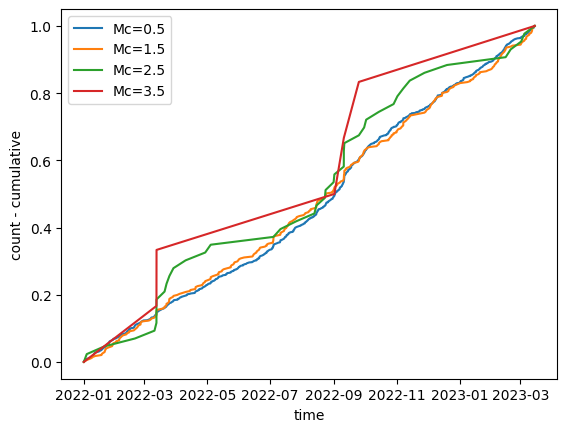

In [7]:
ax = plot_cum_count(df, mcs=np.arange(0.5, 4.0, 1), delta_m=0.1)

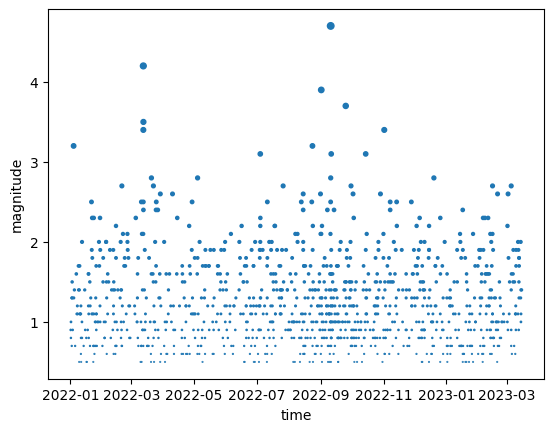

In [8]:
ax = plot_mags_in_time(df)

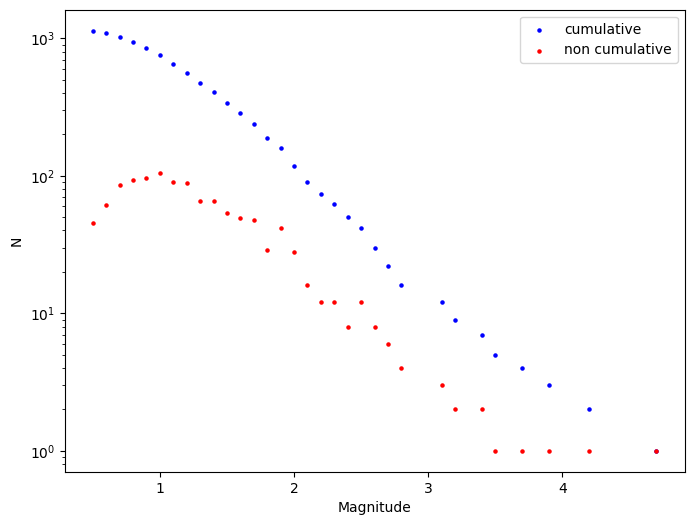

In [9]:
ax = plt.subplots(figsize=(8, 6))[1]

plot_cum_fmd(df['magnitude'], ax=ax, color='blue')
plot_fmd(df['magnitude'], ax=ax, color='red')

ax.legend(['cumulative', 'non cumulative'])

## 2. Generate and bin synthetic earthquakes
<font color=#208de2> First we need to define the number of earthquakes, the b-value and the completeness magnitude. For the b-value, note that beta is defined as the natural logarithm equivalent of the b-value. </font>

In [10]:
from catalog_tools import simulate_magnitudes, bin_to_precision

In [11]:
n = 200
b_value = 1
beta = b_value*np.log(10)
delta_m = 0.1
mc = 3
mc_generation = mc - delta_m / 2

<font color=#208de2> Now we can generate a synthetic magnitude distribution: </font>

In [12]:
mags = simulate_magnitudes(n,beta,mc_generation)

<font color=#208de2> In order to bin the magnitudes, we just need to define the step-size: </font>

In [13]:
mags_binned = bin_to_precision(mags, delta_m)

## 4. Calculate b-values
<font color=#208de2> We estimate the b-value from the binned sample. It is important to pass on the information of which binning (if any) is applied. Also, be cautious that beta is (as above) a factor of np.log(10) different to the b-value. </font>

In [14]:
from catalog_tools import estimate_beta_elst, estimate_beta_utsu, estimate_beta_tinti, estimate_beta_laplace

# Other b-value estimation methods:
# from catalog_tools import estimate_beta_elst, estimate_beta_tinti, estimate_beta_laplace

In [15]:
beta_estimate = estimate_beta_tinti(mags_binned, mc=mc, delta_m=delta_m)
# beta_estimate = estimate_beta_utsu(mags_binned,mc=mc, delta_m=delta_m)
# beta_estimate = estimate_beta_elst(mags_binned, delta_m=delta_m)
# beta_estimate = estimate_beta_laplace(mags_binned, delta_m=delta_m)

<font color=#208de2> We can plot the original and binned magnitudes and their respective b-value estimates now. Note that the data are offset by half the binning size so that the cumulative number is shown correctly. </font>

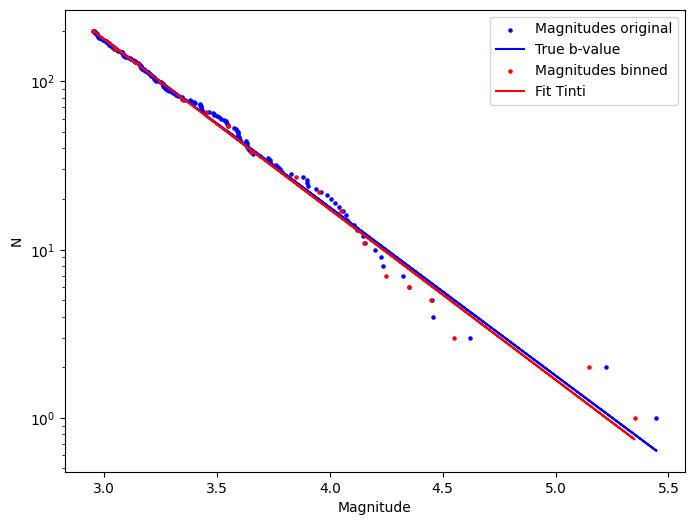

In [16]:
ax = plt.subplots(figsize=(8, 6))[1]

plot_cum_fmd(mags, ax=ax, b_value=b_value, mc=mc - delta_m/2, color='blue')
plot_cum_fmd(mags_binned,ax=ax, b_value=beta_estimate/np.log(10), delta_m=delta_m, color='red')

ax.legend(['Magnitudes original', 'True b-value', 'Magnitudes binned', 'Fit Tinti'])